In [1]:
import math
import numpy as np
import finite
import matplotlib.pyplot as plt

class Timestepper:

    def __init__(self, u, f):
        self.t = 0
        self.iter = 0
        self.u = u
        self.func = f
        self.dt = None

    def step(self, dt):
        self.u = self._step(dt)
        self.t += dt
        self.iter += 1
        
    def evolve(self, dt, time):
        while self.t < time - 1e-8:
            self.step(dt)


class ForwardEuler(Timestepper):

    def _step(self, dt):
        return self.u + dt*self.func(self.u)


class LaxFriedrichs(Timestepper):

    def __init__(self, u, f):
        super().__init__(u, f)
        N = len(u)
        A = sparse.diags([1/2, 1/2], offsets=[-1, 1], shape=[N, N])
        A = A.tocsr()
        A[0, -1] = 1/2
        A[-1, 0] = 1/2
        self.A = A

    def _step(self, dt):
        return self.A @ self.u + dt*self.func(self.u)


class Leapfrog(Timestepper):

    def _step(self, dt):
        if self.iter == 0:
            self.u_old = np.copy(self.u)
            return self.u + dt*self.func(self.u)
        else:
            u_temp = self.u_old + 2*dt*self.func(self.u)
            self.u_old = np.copy(self.u)
            return u_temp


class LaxWendroff(Timestepper):

    def __init__(self, u, func1, func2):
        self.t = 0
        self.iter = 0
        self.u = u
        self.f1 = func1
        self.f2 = func2

    def _step(self, dt):
        return self.u + dt*self.f1(self.u) + dt**2/2*self.f2(self.u)


class Multistage(Timestepper):

    def __init__(self, u, f, stages, a, b):
        super().__init__(u, f)   #Sets self.t = 0
                                 #self.iter = 0
                                 #self.u = u
                                 #self.func = f
                                 #self.dt = None
        pass
    def _step(self, dt):
        N=len(self.u)
        k=np.zeros((stages, N))
        i=0
        while i<stages:
            #print("k: ", k)
            k[i]=f(self.u + dt*a[i] @ k)
            i+=1
        return self.u + dt*b @ k

class AdamsBashforth(Timestepper):

    def __init__(self, u, f, steps, dt):
        super().__init__(u, f)
        pass

    def _step(self, dt):
        pass
    
def plot_2D(matrix, title='FD matrix'):
    lim_margin = -0.05
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot()
    I, J = matrix.shape
    matrix_mag = np.log10(np.abs(matrix))
    ax.pcolor(matrix_mag[::-1])
    ax.set_xlim(-lim_margin, I+lim_margin)
    ax.set_ylim(-lim_margin, J+lim_margin)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')
    plt.title(title)
    plt.tight_layout()

0.15
0.0950875204112609
True


C:\Users\Owner\AppData\Local\Temp/ipykernel_12836/2335680324.py:104: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


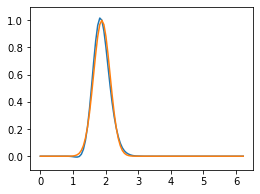

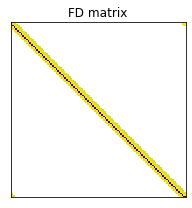

In [21]:
resolution_list = [10, 100, 200, 400]
ITER=1
error_RK_2_2 = {10:0.15, 100:0.15, 200:0.05, 400:0.01}
#print(error_RK_2_2)
#@pytest.mark.parametrize('resolution', resolution_list)
#def test_RK_2_2(resolution):
    
grid = finite.UniformPeriodicGrid(resolution_list[ITER], 2*np.pi)
x = grid.values
IC = np.exp(-(x-np.pi)**2*8)

target = np.exp(-(x-np.pi+2*np.pi*0.2)**2*8)

d = finite.DifferenceUniformGrid(1, 4, grid)
f = lambda u: d @ u

stages = 2
a = np.array([[  0,   0],
              [1/2,   0]])
b = np.array([0, 1])
    
ts = Multistage(IC, f, stages, a, b)

alpha = 0.5
num_periods = 1.2
ts.evolve(alpha*grid.dx, 2*np.pi*num_periods)

error = np.max(np.abs( ts.u - target))
error_est = error_RK_2_2[resolution_list[ITER]]
print(error_est)
print(error)
print(error < error_est)

fig = plt.figure(figsize=(4,3))
p, = plt.plot(x, ts.u)
plt.ylim([-0.1, 1.1])
fig.canvas.draw()
while ts.t < 2*np.pi:
    ts.step(dt)
    if ts.iter % output_cadence == 0:
        p.set_ydata(ts.u)
        fig.canvas.draw()
#plt.plot(x, IC)
plt.plot(x, target)
plot_2D(d.matrix.A)